# JAX를 써봅시다

설치를 할 때 먼저 `jaxlib`을 설치하고 그 버전에 맞는 `jax`를 설치합니다.
```
! pip install jaxlib
! pip install jax==0.3.15
```

In [2]:
from jax import numpy as jnp
from jax import grad
import numpy as np
from plotnine import *
import pandas as pd
from tqdm.notebook import tqdm

간단한 모형을 만들어 봅니다. 
X와 y가 2차함수 형태로 결합된 경우를 생각해 봅니다.

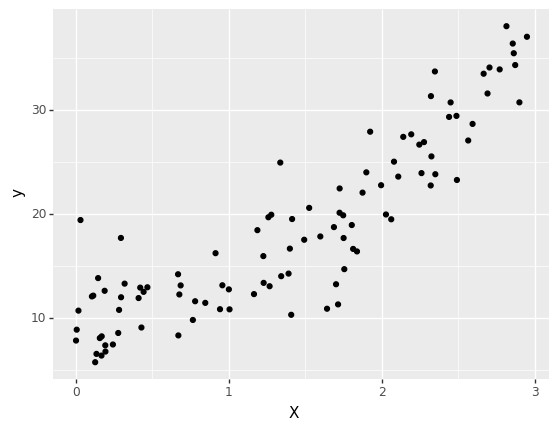

<ggplot: (8775257149410)>

In [3]:
n = 100
X = np.random.uniform(0, 3, size=n)
y = 3 * np.power(X, 2) + np.random.normal(10, 3, size=n)

data = pd.DataFrame(zip(X, y), columns=["X", "y"])
(
    ggplot(data)
    + aes("X", "y")
    + geom_point()
)

선형 모델을 먼저 생각해 봅니다.

In [64]:
w = {"a": 0., "b": 0.}

# set model
def model(w, X):
    return w["a"] * X + w["b"]

# set loss
def loss(w, model, X, y):
    return jnp.power(model(w, X) - y, 2).sum()

# grad loss
dloss = grad(loss)


이제 경사하강법을 활용하여 w를 찾아봅니다.

경사하강법은 말그대로 경사를 구해서 낮은 쪽으로 이동하게 하는 것입니다.

기본적인 아이디어는 예측치와 관측값의 차이를 합치는 손실함수(loss function)을 구합니다. 그리고 파라미터를 손실이 줄어드는 방향(경사, 미분해서 보통 구합니다)으로 조금씩 옮겨가면서 최적의 값을 찾아 한발 한발 나아가는 방식입니다.

수식으로 간단하게 표기해보자면
$$L(\theta) = \sum_i ( f(x_i; \theta) - y)^2$$
로 정의하고 이 $L$을 $\theta$로 미분해 해당 미분값(경사)를 이용해서 낮추는 방향으로 파라미터 $\theta$를 바꿔가면서 찾아가는 방식입니다.

In [65]:
rate = 0.0001

losses = []
ws = []
for i in tqdm(range(2000)):
    l = loss(w, model, X, y)
    ws.append(w.copy())
    losses.append(l)
    if i % 100 == 0:
        print(i, "loss: ", l)
    dw = dloss(w, model, X, y)
    for key in w.keys():
        w[key] -= dw[key]*rate


  0%|          | 0/2000 [00:00<?, ?it/s]

0 loss:  41606.637
100 loss:  1581.1091
200 loss:  1558.6885
300 loss:  1549.7168
400 loss:  1546.124
500 loss:  1544.6855
600 loss:  1544.1096
700 loss:  1543.8787
800 loss:  1543.7864
900 loss:  1543.7493
1000 loss:  1543.7345
1100 loss:  1543.7285
1200 loss:  1543.7263
1300 loss:  1543.7252
1400 loss:  1543.7249
1500 loss:  1543.7247
1600 loss:  1543.7246
1700 loss:  1543.7246
1800 loss:  1543.7246
1900 loss:  1543.7246


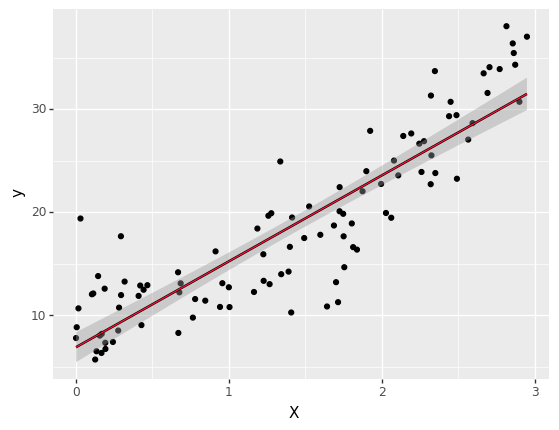

<ggplot: (8775132047089)>

In [66]:
# overlay plots
result_df = pd.DataFrame(zip(X, np.array(model(w, X))), columns=["X", "f"])
(
    ggplot(data=data) +
    aes("X", "y") +
    geom_point() +
    geom_smooth(method="lm") +
    geom_line(data=result_df, mapping=aes("X", "f"),  color="#ff1234")
    
)

In [67]:
def plot(w):# overlay plots
    result_df = pd.DataFrame(zip(X, np.array(model(w, X))), columns=["X", "f"])
    p = (
        ggplot(data=data) +
        aes("X", "y") +
        geom_point() +
        geom_smooth(method="lm") +
        geom_line(data=result_df, mapping=aes("X", "f"),  color="#ff1234")    
    )
    return p

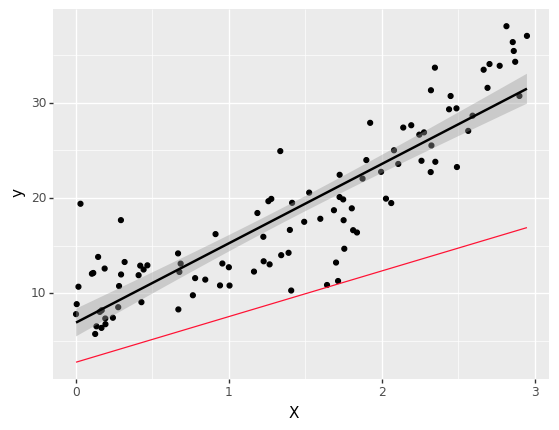

<ggplot: (8775127376119)>

In [68]:
plot(ws[10])

In [87]:
dfs = [pd.DataFrame(zip(map(int, np.ones_like(X)*i), X, np.array(model(ws[i], X))), columns=["i", "X", "f"]) for i in range(0, 100, 10)]
df = pd.concat(dfs)

처음에는 많이 차이나지만 점점 해석적으로 계산한 선형 회귀 값과 유사해지는 것을 볼 수 있습니다.

이 경사하강법의 장점은 손실함수를 정의 할 수만 있다면 적용할 수 있어 유연하게 많은 곳에 적용할 수 있습니다.

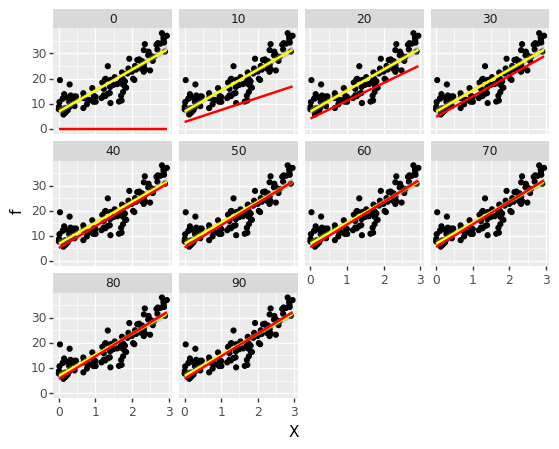

<ggplot: (8775126430660)>

In [96]:
p = (
ggplot(data=df) +
aes(x="X", y="f") +
geom_point(data=data, mapping=aes("X", "y")) +
geom_smooth(data=data, method="lm", mapping=aes("X", "y"), color="yellow") +
geom_line(color="red", size=1) +
facet_wrap("i")
)

p